In [17]:
import numpy as np

def read_input(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines() # list of strings, each string is a line of the file
    
    goal_coords = tuple(map(int, lines[0].strip().split()))
    goal_coords_reversed = np.flip(goal_coords) 
    grid = np.array([list(map(int, line.strip())) for line in lines[1:]]) # grid is a matrix of 1s and 0s
    grid_reversed = np.flip(grid, axis=0)
    if goal_coords_reversed[0] >= grid.shape[0] or goal_coords_reversed[1] >= grid.shape[1]:
        raise ValueError("Goal coordinates are outside the grid")
    return goal_coords_reversed, grid_reversed

In [18]:
def get_reward(next_state, action, goal, grid, obstacle_punishment, wait_punishment):
    goal_x, goal_y = goal
    distance = np.linalg.norm(np.array([goal_x, goal_y]) - next_state)
    
    if grid[next_state] == 1:
        return obstacle_punishment  # obstacle
    elif np.array_equal(next_state, goal):
        return 100
    elif action == (0, 0) and not np.array_equal(next_state, goal):
        return wait_punishment  # wait action in non-goal state
    else:
        return -distance  # default case        

In [19]:
import random

def get_next_state(state, action, action_probabilities, grid, goal):
    # each action has 3 possible outcomes
    action_mapping = {
        (-1, 1) : [(-1, 0), (-1, 1), (0, 1)],
        (0, 1) : [(-1, 1), (0, 1), (1, 1)],
        (1, 1) : [(0, 1), (1, 1), (1, 0)],
        (-1, 0) : [(-1, -1), (-1, 0), (-1, 1)],
        (0, 0) : [(0, 0), (0, 0), (0, 0)],
        (1, 0) : [(1, 1), (1, 0), (1, -1)],
        (-1, -1) : [(0, -1), (-1, -1), (-1, 0)],
        (0, -1) : [(1, -1), (0, -1), (-1, -1)],
        (1, -1) : [(0, 1), (1, -1), (-1, 0)]
    }
    
    possible_actions = action_mapping[action]
    # np.random.choice must receive a 1-dim list as first argument, or a scalar (and then it converts it to a list [0 .. scalar-1])
    actual_action_index = np.random.choice(len(possible_actions), p = action_probabilities)
    actual_action = possible_actions[actual_action_index]
    next_state = (state[0] + actual_action[0], state[1] + actual_action[1])

    # i move if next state is within bounds and i am not on an obstacle
    if 0 <= next_state[0] < grid.shape[0] and 0 <= next_state[1] < grid.shape[1] and grid[state[0], state[1]] == 0 and not np.array_equal(state, goal): 
        return next_state
    else:
        return state  # no movement if next state is out of bounds or i am currently on an obstacle

In [20]:
# now i know how to get the next state given one
def choose_action(state, actions, q_table, epsilon):
    action_idx = None
    if random.uniform(0, 1) < epsilon:
        action_idx = random.randint(0, len(actions) - 1) # explore (get a random action)
    else:
        action_idx = np.argmax(q_table[state[0], state[1]]) # exploit (get the best action yet, argmax return index)
    
    return actions[action_idx]

In [21]:
def update_q_table(state, action_index, next_state, reward, q_table, gamma, alpha):
    best_q_value = np.max(q_table[next_state[0], next_state[1]])
    previous_q_value = q_table[state[0], state[1], action_index]
    increment = reward + gamma * best_q_value - previous_q_value
    q_table[state[0], state[1], action_index] += alpha * increment

In [22]:
def generate_episode(grid, goal, q_table, actions, action_probabilities, obstacle_punishment, wait_punishment, max_episode_length, alpha, gamma, epsilon): # generate 1 (complete) episode
        state = (random.randint(0, grid.shape[0] - 1), random.randint(0, grid.shape[1] - 1)) # random initial state
        step_count = 0
        while not np.array_equal(state, goal) and step_count < max_episode_length:
            action = choose_action(state, actions, q_table, epsilon) # choose the best action with "epsilon-greedy policy"
            # apply action and observe next state and reward
            next_state = get_next_state(state, action, action_probabilities, grid, goal)
            reward = get_reward(next_state, action, goal, grid, obstacle_punishment, wait_punishment)

            # update q_table
            action_index = actions.index(action)
            update_q_table(state, action_index, next_state, reward, q_table, gamma, alpha)
            state = next_state
            step_count += 1

In [23]:
# after generating all the episodes, i can get the best policy from the q_table:
def get_policy(grid, goal, q_table):
    policy = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if not np.array_equal((i, j), goal):
                policy[i, j] = np.argmax(q_table[i, j]) # in state (i,j), choose the action with the highest q-value
    return policy

In [24]:
from matplotlib import pyplot as plt

def plot_policy(grid, goal, actions, policy):
    fig, ax = plt.subplots()
    # draw arrows representing the action in each cell
    U = np.zeros_like(grid, dtype = float)
    V = np.zeros_like(grid, dtype = float)

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if not np.array_equal((i, j), goal):
                action = actions[policy[i, j]]
                U[i, j] = action[1] 
                V[i, j] = action[0] 
            if grid[i, j] == 1:
                ax.fill([j, j, j+1, j+1], [i, i+1, i+1, i], 'k')  # draw a black square on obstacle cell

    ax.quiver(U, V)
    ax.scatter(goal[1], goal[0], color='r')  # draw a red dot on the goal cell
    plt.show()

In [25]:
from tqdm.notebook import tqdm

# now i can put everything together:
def q_learning(file_path, actions, action_probabilities, obstacle_punishment, wait_punishment, episodes_number, max_episode_length, alpha, gamma, epsilon):
    goal, grid = read_input(file_path)
    
    q_table = np.zeros((grid.shape[0], grid.shape[1], 9)) # initialize q_table with zeros

    for _ in tqdm(range(episodes_number), desc = "Episode"):
        generate_episode(grid, goal, q_table, actions, action_probabilities, obstacle_punishment, wait_punishment, max_episode_length, alpha, gamma, epsilon)

    policy = get_policy(grid, goal, q_table)
    plot_policy(grid, goal, actions, policy)

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

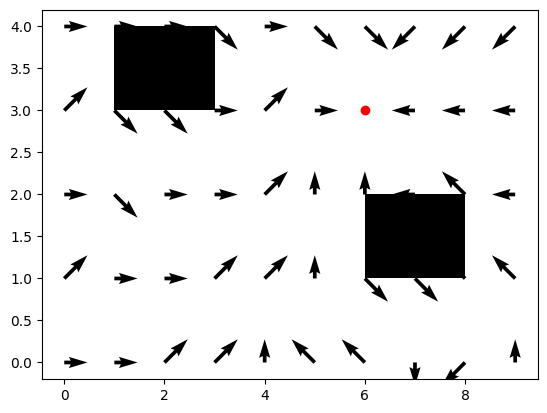

In [26]:
episodes_number = 1000
max_episode_length = 1000
alpha = 0.8
gamma = 0.1 # only consider short-term rewards
epsilon = 0.1
action_probabilities = [0.05, 0.9, 0.05]
obstacle_punishment = -10
wait_punishment = -1000
file_path = '../resources/small_map.txt'
actions = [(-1, 1), (0, 1), (1, 1),
           (-1, 0), (0, 0), (1, 0),
           (-1, -1), (0, -1), (1, -1)]

q_learning(file_path, actions, action_probabilities, obstacle_punishment, wait_punishment, episodes_number, max_episode_length, alpha, gamma, epsilon)